In [22]:
from ase.build import bulk
from ase.optimize import GPMin
from ase.calculators.emt import EMT
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [23]:
# Build a silver (Ag) unit cell

ag = bulk("Ag", "fcc", cubic=True)
view(ag, viewer="x3d")

In [24]:
calc = EMT()    # Attach calculator to Ag unit cell
ag.calc = calc
opt = GPMin(ag)
opt.run(fmax=.05)   #Optimize the system


       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000


True

In [25]:
cell = ag.cell
print(cell.lengths())   # Retrieve lattice constant and unit cell volume
print(cell.volume)


[4.09 4.09 4.09]
68.417929


The optimized lattice constant: 4.09 Å

Equilibrium cell volume: 68.42 Å<sup>3

In [26]:
v0 = cell.volume
volume_range = np.arange(0.8 * v0, 1.2 * v0, .02 * v0)  # Create range of volumes

In [27]:
# Relax the atomic positions of Ag unit cells w/ different volumes

potential_energies = [] # Initialize lists to store potential energies, lattice constants, and volumes
lengths = []
volumes = []

for vol in volume_range:
    lattice_const = np.cbrt(vol)
    new_ag = bulk("Ag", "fcc", a=lattice_const, cubic=True)
    new_ag.calc = calc
    opt.run(fmax=.05)
    new_ag_cell = new_ag.cell
    potential = new_ag.get_potential_energy()
    lengths.append([new_ag_cell.lengths()])
    potential_energies.append(potential)
    volumes.append(new_ag_cell.volume)

       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 12:51:27        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 1

In [28]:
# Verify that volume was fixed during the simulation
test = volume_range - volumes
test

array([ 7.10542736e-15, -2.84217094e-14, -7.10542736e-15,  0.00000000e+00,
        7.10542736e-15,  3.55271368e-14,  2.13162821e-14, -2.84217094e-14,
       -1.42108547e-14,  0.00000000e+00, -1.42108547e-14,  0.00000000e+00,
       -1.42108547e-14, -1.42108547e-14, -5.68434189e-14,  0.00000000e+00,
        0.00000000e+00,  1.42108547e-14,  2.84217094e-14,  0.00000000e+00])

In [29]:
np.where(potential_energies == np.min(potential_energies))
print(f"The potential is minimized at V = {volume_range[9]} A^3")

The potential is minimized at V = 67.04957042 A^3


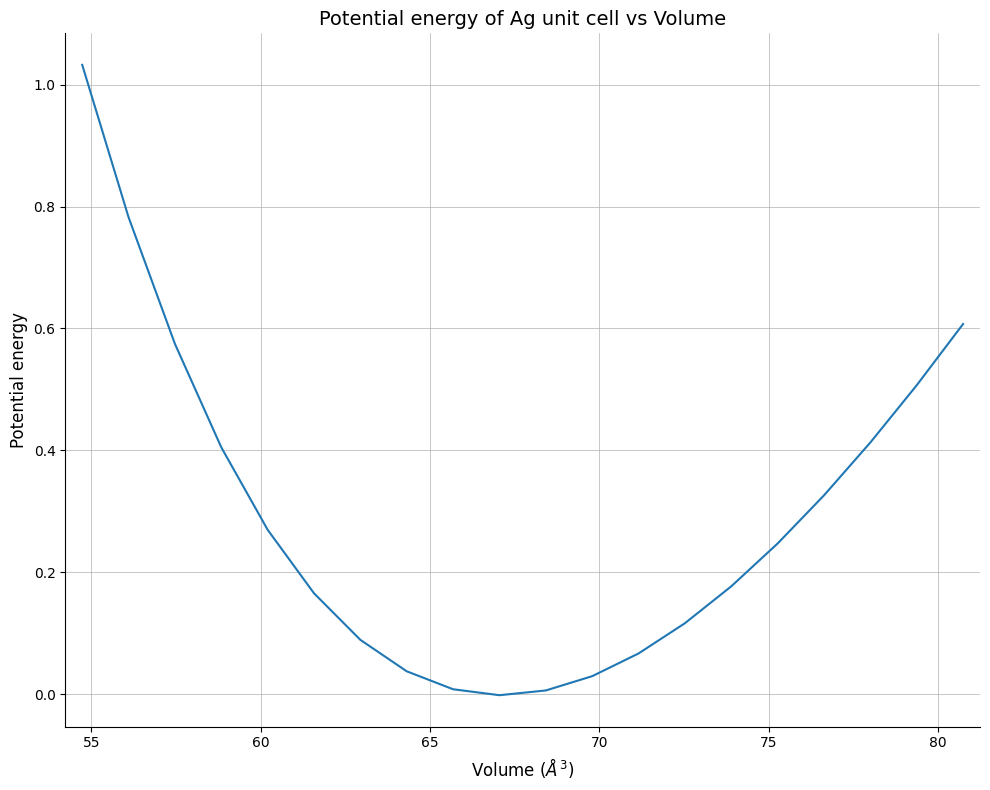

In [30]:
plt.figure(figsize=(10,8))
plt.plot(volume_range, potential_energies, label="Data")
plt.xlabel("Volume ($Å^3$)", fontsize=12)
plt.ylabel("Potential energy", fontsize=12)
plt.title("Potential energy of Ag unit cell vs Volume", fontsize=14)
plt.grid(linewidth=0.5)
plt.xlim(volume_range[0] - 0.5, volume_range[-1] + 0.5)
# plt.axvline(67.04957042, linestyle="--", label="Equilibrium cell volume", color="black", alpha=0.5, zorder=1)
plt.gca().spines[["top", "right"]].set_visible(False)
# plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("Ag_U_vs_V.png")

# Volume discrepency

The equilibrium cell volume, calculated by the cube of the optimized lattice constant (**68.42 Å<sup>3</sup>**) is larger than the volume that minimizes the potential energy (**67.05 Å<sup>3</sup>**). Since the optimized lattice constant is exactly in agreement with literature values, the method for potential energy calculalation contains contains errors. The difference between the cell volumes is low, but other potential energy calculators should be tried to find a method that is in more agreement with literature

In [31]:
# Define the Murnaghan EOS
def murnaghan(V, k0, k0_prime, ref_volume=v0):
    """
    The Murnaghan equation of state

    Parameters:
        v: float or int
            Volume of the solid under compression
        k0: float or int
            Bulk modulus at the reference volume when P = 0
        k0_prime: float or int
            Derivative of the modulus with respect to pressure while temperature and moles
            are held constant
        ref_volume: float or int
            Reference volume
    Returns:
        P: float or int
            Pressure of the solid
    
    
    """
    coeff = k0 / k0_prime
    return coeff * (((V/ref_volume) ** -k0_prime) - 1)

In [32]:
# Define the potential, U(v), derived from the Murnaghan EOS 
def murn_poten(V, k0, k0_prime, u0, ref_volume=v0):
    """
    The potential, U(v), derived from the Murnaghan equation of state

    Parameters:
        v: float or int
            Volume of the solid under compression
        k0: float or int
            Bulk modulus at the reference volume when P = 0
        k0_prime: float or int
            Derivative of the modulus with respect to pressure while temperature and moles
            are held constant
        u0: float or int
            Potential energy of the solid at the reference volume when P = 0
        ref_volume: float or int
            Reference volume
    Returns:
        U: float or int
            Potential energy of the solid
    
    
    """
    
    return u0 + ((k0 * V) / k0_prime) * (((ref_volume / V) ** k0_prime) / (k0_prime - 1) + 1) - (k0 * ref_volume) / (k0_prime - 1)

In [33]:
# Extract K0 and K0' from the Murnaghan EOS
parameters_murn, covariance_murn = curve_fit(murnaghan, volume_range, potential_energies, p0=[50,50])
print(f"K0: {parameters_murn[0]:.3}")
print(f"K0': {parameters_murn[1]:.3}")


K0: 0.324
K0': 18.9


In [34]:
# Extract K0 and K0' from U(v)
parameters_pot, covariance_pot = curve_fit(murn_poten, volume_range, potential_energies, p0=[50,50,50])
print(f"K0: {parameters_pot[0]:.3}")
print(f"K0': {parameters_pot[1]:.3}")
print(f"U0: {parameters_pot[2]:.3}")

K0: 0.632
K0': 0.696
U0: -0.00458


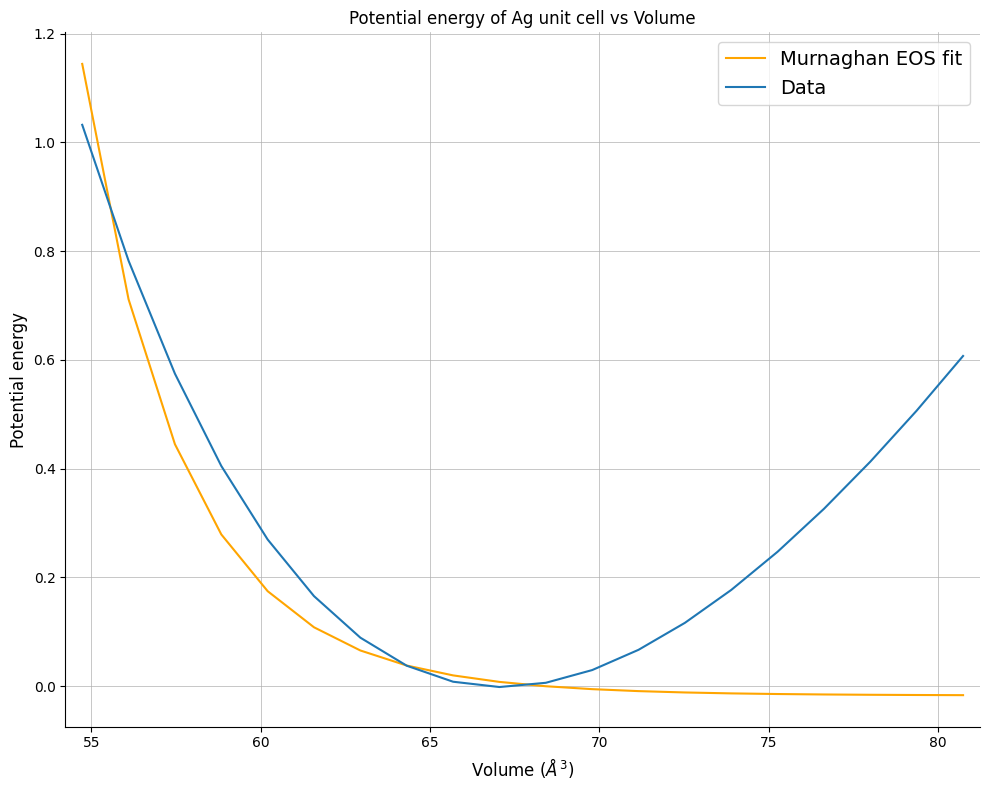

In [35]:

plt.figure(figsize=(10,8))
plt.plot(volume_range, murnaghan(volume_range, parameters_murn[0], parameters_murn[1]), label="Murnaghan EOS fit", color="orange")
plt.plot(volume_range, potential_energies, label="Data", color="#1f77b4")
plt.xlabel("Volume ($Å^3$)", fontsize=12)
plt.ylabel("Potential energy", fontsize=12)
plt.xlim(volume_range[0] - 0.5, volume_range[-1] + 0.5)
plt.title("Potential energy of Ag unit cell vs Volume", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.grid(linewidth=0.5)
# plt.axvline(67.04957042, linestyle="--", label="Equilibrium cell volume", color="black", alpha=0.5, zorder=1)
plt.legend(fontsize=14)
plt.savefig("EOS_Fit_Ag_U_vs_V.png")
plt.tight_layout()
plt.show()

In [36]:
standard_error = np.sqrt(np.diag(covariance_murn))
print(f"The fitted K0 is {parameters_murn[0]:.3} with a standard error of {standard_error[0]:.3}")
print(f"The fitted K0' is {parameters_murn[1]:.3} with a standard error of {standard_error[1]:.3}")

The fitted K0 is 0.324 with a standard error of 0.397
The fitted K0' is 18.9 with a standard error of 7.61


# Fit to the Murnaghan EOS

The standard error of the bulk modulus is larger than the value obtained for the bulk modulus using the Murnaghan equation as a fit. Furthermore, the standard error of the derivative of the bulk modulus with respect to pressure is nearly one-half than the fitted parameter. 

The plot of the data and the fitted equation shows that this discrepency is the result of the fit deviating from the data at volumes greater than 68.4 Å<sup>3</sup>, the equilibrium cell volume. At volumes larger than the equilibrium cell volume, the Murnaghan equation underestimates the potential energy of the Ag unit cell. Additionally, the plot shows that the underestimation continues to increase at larger volumes. 

However, at volumes shorter than the equilibrium cell volume, the Murhnaghan equation fits th data quite well. Additionally, the plot shows that at volumes less than 56.1 Å<sup>3</sup>, the Murnaghan overestimates the data.

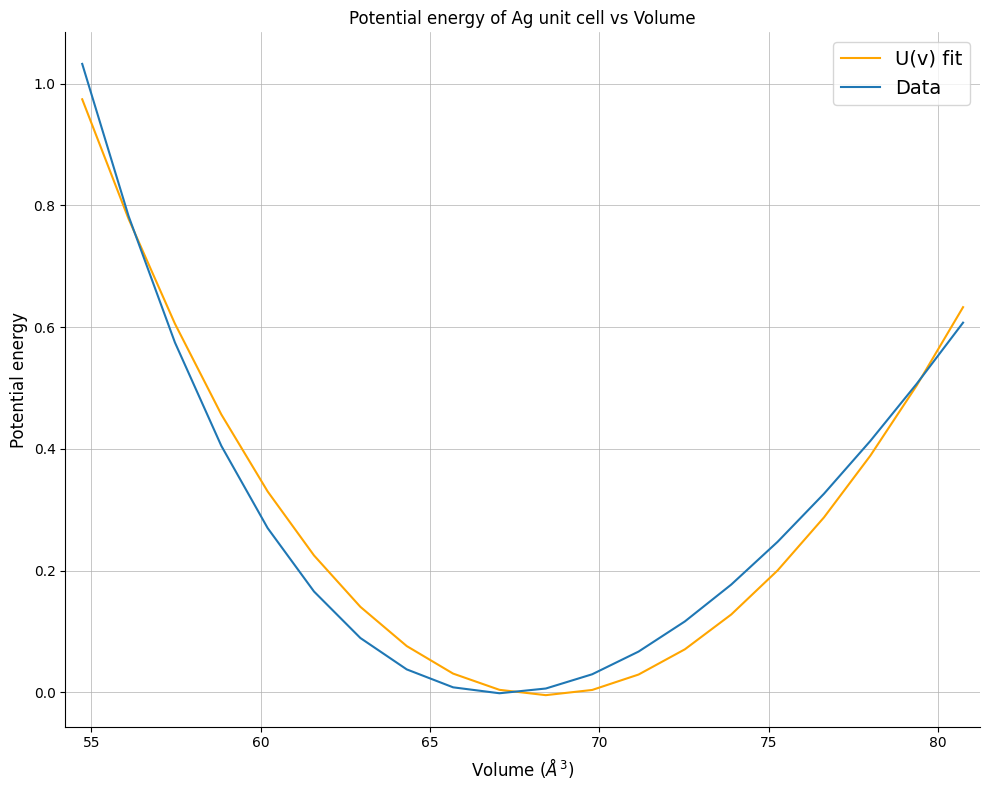

In [37]:
plt.figure(figsize=(10,8))
plt.plot(volume_range, murn_poten(volume_range, parameters_pot[0], parameters_pot[1], parameters_pot[2]), label="U(v) fit", color="orange")
plt.plot(volume_range, potential_energies, label="Data", color="#1f77b4")
plt.xlabel("Volume ($Å^3$)", fontsize=12)
plt.ylabel("Potential energy", fontsize=12)
plt.xlim(volume_range[0] - 0.5, volume_range[-1] + 0.5)
plt.title("Potential energy of Ag unit cell vs Volume", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.grid(linewidth=0.5)
# plt.axvline(67.04957042, linestyle="--", label="Equilibrium cell volume from data", color="black", alpha=0.5, zorder=1)
plt.legend(fontsize=14)
plt.savefig("Pot_Fit_Ag_U_vs_V.png")
plt.tight_layout()
plt.show()

In [38]:
# Calculate statistics for the parameters extracted from the U(v) fit

standard_error = np.sqrt(np.diag(covariance_pot))
print(f"The fitted K0 is {parameters_pot[0]:.3} with a standard error of {standard_error[0]:.3}")
print(f"The fitted K0' is {parameters_pot[1]:.3} with a standard error of {standard_error[1]:.3}")
print(f"The fitted U0' is {parameters_pot[2]:.3} with a standard error of {standard_error[2]:.3}")

# Calculate the volume that minimizes U(v)
derived_potentials = murn_poten(volume_range, parameters_pot[0], parameters_pot[1], parameters_pot[2])
ind_min_potential = np.where(derived_potentials == np.min(derived_potentials))[0][0]
print(f" U(v) is minimzed at: {volume_range[ind_min_potential]:.4}")

The fitted K0 is 0.632 with a standard error of 0.0254
The fitted K0' is 0.696 with a standard error of 0.458
The fitted U0' is -0.00458 with a standard error of 0.0144
 U(v) is minimzed at: 68.42


# Fit to U(v)
Fitting U(v) to the potential energy data calculated with the EMT potential is much better than fitting the Murnaghan EOS itself, which makes sense since the EOS does not calculate potential energies.

The standard error for the bulk modulous is very small compared to the value for the bulk modulous whereas the standard error for the bulk modulous prime is almost equal to the value itself, meaning there is much more confidence in the value for the bulk modulous.

The cell volume that minimzes U(v) (**68.42 Å<sup>3</sup>**) is slightly larger than the cell volume calculated from the EMT potential (**67.05 Å<sup>3</sup>**) . However, it is in exact agreement with the equilibrium cell volume found in the literature (**68.42 Å<sup>3</sup>**), further suggesting that the EMT potential has some issues with the way it calculates potential energy.

The bulk modulous 

Overall, this work shows that the Murnaghan equation of state describes an Ag unit cell extremely well.